In [77]:
import re
import spacy
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from string import punctuation
from wordcloud import WordCloud, STOPWORDS

from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.corpus import stopwords


sns.set_style('whitegrid')
%matplotlib inline

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

from nltk import bigrams
import pickle

import os
import gensim

from pprint import pprint

import matplotlib.colors as mcolors
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.utils import  simple_preprocess
from gensim.models import CoherenceModel
from collections import Counter
import pyLDAvis
import pyLDAvis.gensim_models
from wordcloud import WordCloud 

In [15]:
survey = pd.read_csv("/Users/swagyangjh/Desktop/Processed_survey.csv")


In [16]:
sent_topics_sorteddf_mallet = pd.DataFrame()
df_dominant_topic = pd.DataFrame()
vis = 0

In [17]:
    def plot_10_most_common_words(count_data, count_vectorizer):
        import matplotlib.pyplot as plt
        words = count_vectorizer.get_feature_names()
        total_counts = np.zeros(len(words))
        for t in count_data:
            total_counts+=t.toarray()[0]

        count_dict = (zip(words, total_counts))
        count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
        words = [w[0] for w in count_dict]
        counts = [w[1] for w in count_dict]
        x_pos = np.arange(len(words)) 

        plt.figure(2, figsize=(15, 15/1.6180))
        plt.subplot(title='10 most common words')
        sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
        sns.barplot(x_pos, counts, palette='husl')
        plt.xticks(x_pos, words, rotation=90) 
        plt.xlabel('words')
        plt.ylabel('counts')
        plt.show()

In [18]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('[,\.!?]', '', sent)  # remove emails
        sent = sent.lower()  
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent) 

In [19]:
# structure the main topic
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp[:10]])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,10), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [20]:
# delete the bigrams which do not contain topic words
def word_drop_keywords(x):
    arr = [i.strip() for i in  x[0].split(",") if i.strip() ]
    if len(arr) >=5:
        key_words = arr[:5]
    else:
        key_words = arr
    words = x[1]
    keep_words = []
    for i in range(len(words)):
        
        if i == 0:
            if len(set(words[i:i+1])&set(key_words)) > 0 :
                
                keep_words.append(words[i])
        elif i < len(words)-1 and i > 0:
            if len(set(words[i:i+2])&set(key_words)) > 0 or len(set(words[i-1:i+1])&set(key_words)) > 0 :

                keep_words.append(words[i])
        else:
            if words[i-1] in key_words:
                keep_words.append(words[i])
    return keep_words

In [60]:
def QA(datasetnum,method_justification):

    # Dataset
    dataset = survey.loc[survey['Dataset']==datasetnum]

    # Jusitification
    justification = dataset[method_justification]
    justification
    clean_justification = justification.dropna(axis=0,how='all')  
    clean_justification = clean_justification[:]
    clean_justification.head()

    # Stopwords
    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'subject', 're', 'image','edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'rather', 'lot', 'make', 'want', 'seem', 'run', 'need', 'even', 'even', 'also', 'may', 'take', 'come'])
    stop_words.extend(["patients", "floor", "icu","alive","discharged", "er", 'two','three'])


    data = clean_justification.tolist()

    data_words = list(sent_to_words(data))

    # Remove Stop Words
    sentences=[]
    for line in data_words:
        try:
            segs = [i for i in line if i not in stop_words]
            sentences.append(segs)
        except:
            print (line)
            continue


    # Create Dictionary
    id2word = Dictionary(sentences)

    # Create Corpus: Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in sentences]

    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=1, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=10,
                                               passes=10,
                                               alpha='symmetric',
                                               iterations=100,
                                               per_word_topics=True)


    # 



    df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=sentences)

    # Format
    global df_dominant_topic
    df_dominant_topic = df_topic_sents_keywords.reset_index()
    df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
    #print(df_dominant_topic.head(10))

    """get samples of sentences that most represent a given topic."""
    global sent_topics_sorteddf_mallet
    pd.options.display.max_colwidth = 100

    sent_topics_sorteddf_mallet = pd.DataFrame()
    sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

    for i, grp in sent_topics_outdf_grpd:
        sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                                 grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                                axis=0)
    
    # Reset Index    
    sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

    # Format
    sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

    # Show
    #print(sent_topics_sorteddf_mallet.head(10))

    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

    cloud = WordCloud(stopwords=stop_words,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    topics = lda_model.show_topics(formatted=False)

    fig, axes = plt.subplots(1, 2, figsize=(10,10), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')


    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

    # Initialise the count vectorizer with the English stop words
    count_vectorizer = CountVectorizer(stop_words='english')
    # Fit and transform the processed titles
    count_data = count_vectorizer.fit_transform(clean_justification)
    # Visualise the 10 most common words
    plot_10_most_common_words(count_data, count_vectorizer)


#     new_text = df_dominant_topic[["Keywords","Text"]].apply(lambda x:word_drop_keywords(x),axis=1)
#     new_text = [i for i in new_text if len(i) >0]
#     new_data = [" ".join(i) for i in new_text ]
    pyLDAvis.enable_notebook()
    global vis
    vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    



patients, floor, icu,alive,discharged, er, two.

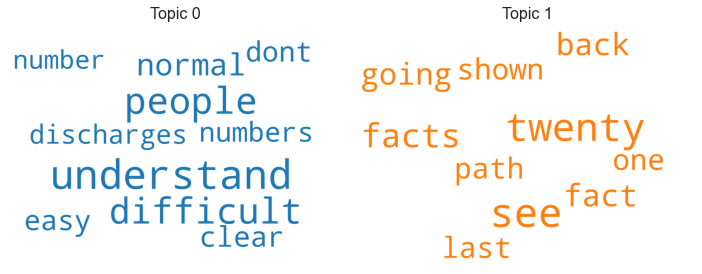

/Users/swagyangjh/opt/anaconda3/envs/R2F/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/swagyangjh/opt/anaconda3/envs/R2F/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


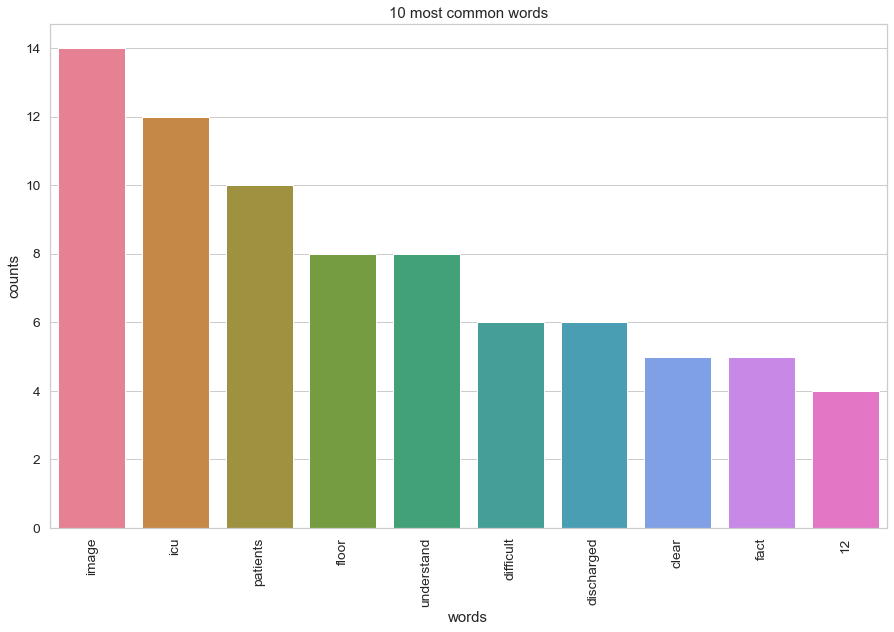

/Users/swagyangjh/opt/anaconda3/envs/R2F/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/Users/swagyangjh/opt/anaconda3/envs/R2F/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/swagyangjh/opt/anaconda3/envs/R2F/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/swagyangjh/opt/anaconda3/envs/R2F/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  

In [76]:
dataset0 = QA('0','ss_Justification')


In [70]:
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.975452,"understand, easy, numbers, arrival, number, follow, chart, fairly, add, discharge","[numbers, diagram, correlate, facts, presented, scenario, whole, flow, chart, difficult, read, e..."
1,1.0,0.973107,"normal, people, shows, going, data, nothing, one, wrong, given, went","[graph, shows, nothing, sort, completely, confused, interpret, shows, nothing, regards, moved, n..."


In [71]:
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.932028,"understand, easy, numbers, arrival, number, follow, chart, fairly, add, discharge","[bit, harder, understand, numbers, dont, quite, match]"
1,1,0.0,0.886142,"understand, easy, numbers, arrival, number, follow, chart, fairly, add, discharge","[easy, understand, data, fact, read]"
2,2,0.0,0.924852,"understand, easy, numbers, arrival, number, follow, chart, fairly, add, discharge","[clear, understand, facts, match, numbers, displayed]"
3,3,1.0,0.909044,"normal, people, shows, going, data, nothing, one, wrong, given, went","[doesnt, show, numbers, discharge, died, versus]"
4,4,1.0,0.924513,"normal, people, shows, going, data, nothing, one, wrong, given, went","[little, confusing, tell, went, emergency, went]"
5,5,0.0,0.916141,"understand, easy, numbers, arrival, number, follow, chart, fairly, add, discharge","[easy, understand, activities, fact, shown, consistent]"
6,6,1.0,0.951584,"normal, people, shows, going, data, nothing, one, wrong, given, went","[activity, going, back, illustrated, expect, branch, indicated, emergency, stage, graph]"
7,7,0.0,0.959409,"understand, easy, numbers, arrival, number, follow, chart, fairly, add, discharge","[good, flow, generally, easy, follow, splits, logical, ways, minimal, ambiguity, outcomes, every..."
8,8,1.0,0.917617,"normal, people, shows, going, data, nothing, one, wrong, given, went","[splits, feel, bit, unlabeled, overall, images, better]"
9,9,0.0,0.827063,"understand, easy, numbers, arrival, number, follow, chart, fairly, add, discharge","[somewhat, difficult]"


In [72]:
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.096262  0.0       1        1  53.991665
1     -0.096262  0.0       2        1  46.008335, topic_info=           Term      Freq     Total Category  logprob  loglift
89       normal  4.000000  4.000000  Default  30.0000  30.0000
58       people  4.000000  4.000000  Default  29.0000  29.0000
6    understand  4.000000  4.000000  Default  28.0000  28.0000
8          easy  4.000000  4.000000  Default  27.0000  27.0000
109       shows  3.000000  3.000000  Default  26.0000  26.0000
..          ...       ...       ...      ...      ...      ...
15    discharge  1.444452  3.010513   Topic2  -4.1442   0.0420
4       numbers  1.360013  4.527797   Topic2  -4.2044  -0.4264
9          fact  1.172409  2.376167   Topic2  -4.3529   0.0699
64          die  1.161319  2.125766   Topic2  -4.3624   0.1718
26        shown  1.161421  2.557625   Topic2  -4.3623  -0.0131

[102 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
24        1  0.610609  activities
60        1  1.103551         add
114       2  0.657299      anyone
61        1  0.595729     arrival
61        2  0.297864     arrival
...     ...       ...         ...
78        1  0.828652      things
6         1  1.007148  understand
23        2  0.961349        went
79        1  0.828652       whole
108       2  0.818645       wrong

[74 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

/Users/swagyangjh/opt/anaconda3/envs/R2F/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/swagyangjh/opt/anaconda3/envs/R2F/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/swagyangjh/opt/anaconda3/envs/R2F/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/swagyangjh/opt/anaconda3/envs/R2F/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/swagyangjh/op